# Exploring News Topics with BERTopic and BERT Embeddings

In this notebook we dive into [**BERTopic**](https://github.com/MaartenGr/BERTopic), a cutting-edge topic modeling technique, to explore any text dataset to cluster documents into topics. In this notebook we will use the [**BBC News dataset**](https://huggingface.co/datasets/SetFit/bbc-news) to explore the semantic structure of the news articles.

BERTopic doesn't rely on traditional word co-occurrence counts like LDA — instead, it uses **semantic vector representations** generated by powerful language models like BERT. This makes it particularly good at capturing **meaning**, **context**, and **similarity** between documents.

---

## 🌍 Why BERT Makes This Possible

Pre-trained models like `bert-base-uncased` are trained on massive corpora and thus encode a **rich, general understanding of language**. This means that even if the model has never seen your exact data, it can still produce embeddings that:

- Cluster similar sentences or documents together,
- Reflect nuanced semantic distinctions (e.g., between “economy” and “finance”),
- Work well even *without any additional training*.

These embeddings capture not just the presence of words, but their **contextual meaning**.

🔧 However, in some cases we might want even better clustering. That's where **fine-tuning** comes in:
- If we fine-tune a BERT model on a **sentence similarity task** (like Semantic Textual Similarity Benchmark – STSb), the embeddings become **even better** at mapping semantically similar texts closer together.
- In this notebook, we'll use a version already optimized for that: `all-MiniLM-L6-v2` from the [SentenceTransformers](https://www.sbert.net/) library.

This lets us take **pre-trained general knowledge**, add **task-specific learning**, and apply it to **unsupervised exploration** like topic modeling — no labels needed!

---

## 📋 What You'll Learn

| Section | Description |
|--------|-------------|
| **1. Quick Demo** | Run BERTopic on BBC News using `all-MiniLM-L6-v2` and generate cluster summaries with a LLM via `LiteLLM`. |
| **2. Visualize Results** | Use BERTopic's built-in visual tools to explore topic clusters and keywords. |
| **3. Interactive Exploration** | Dive deeper into specific clusters and inspect example articles. |
| **4. Step-by-Step Breakdown** | Understand the entire BERTopic pipeline: embeddings → dimensionality reduction → clustering → topic representation. |

---

## 🧰 Libraries We'll Use

- `BERTopic` for topic modeling
- `sentence-transformers` for generating document embeddings
- `datasets` from Hugging Face to load and clean data
- `LiteLLM` for language model-powered summaries
- `plotly` and `pandas` for interactive data exploration

--- 

## 💾 Load the BBC News Dataset

We’ll start by loading the **BBC News** dataset using the Hugging Face `datasets` library.

This dataset contains short news articles from five topics: `business`, `entertainment`, `politics`, `sport`, and `tech`.

Each article is represented as a short paragraph of text, and labeled with its corresponding topic. While we won’t use the labels for **unsupervised topic modeling**, they are useful later for evaluation and visualization.

Let’s load the data and preview a few examples. We will concatenate the test

In [1]:
from datasets import load_dataset
import pandas as pd

# Load the dataset
train_dataset = load_dataset("SetFit/bbc-news", split="train")
test_dataset = load_dataset("SetFit/bbc-news", split="test")

# Convert to pandas DataFrame for easier handling
df = pd.concat([train_dataset.to_pandas(), test_dataset.to_pandas()]).reset_index(drop=True)
df = df.rename(columns={"text": "document", "label": "true_label"})

# Show basic info
print(f"Dataset size: {len(df)} documents")
df.head()

Dataset size: 2225 documents


,document,true_label,label_text
0,wales want rugby league training wales could f...,2,sport
1,china aviation seeks rescue deal scandal-hit j...,1,business
2,rock band u2 break ticket record u2 have smash...,3,entertainment
3,markets signal brazilian recovery the brazilia...,1,business
4,tough rules for ringtone sellers firms that fl...,0,tech


## Quick Intro to BERTopic + LiteLLM

Now let’s briefly introduce the key tools we’ll use to extract and **interpret** topics:

---

### 🧠 What is BERTopic?

[**BERTopic**](https://github.com/MaartenGr/BERTopic) is a modern topic modeling framework that:
- Uses **pretrained embeddings** (e.g., MiniLM, BERT) to compute document similarity in a meaningful way.
- Applies **UMAP** for dimensionality reduction and **HDBSCAN** for clustering documents.
- Can plug in LLMs to generate **human-readable topic representations** like titles and summaries.

This helps us group documents by theme **without supervision**, and make those clusters interpretable using LLM-generated descriptions.

---

### 💬 What is LiteLLM?

[**LiteLLM**](https://github.com/BerriAI/litellm) is a lightweight interface that lets us query LLM APIs (like OpenAI’s GPT-4o) with ease.

We’ll use it to:
- Generate a **title** and a **summary** for each topic.
- Customize the prompt for both — so the LLM knows exactly what to generate based on the documents and keywords in a cluster.

---

### 🧠 Our Prompting Strategy

We're using two distinct prompts to refine the topic representation, to make them human-readable.

1. **Title Prompt**
```text
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the above information, please provide a concise title for this topic

Format your response as:
title: <title>
````

2. **Summary Prompt**

```text
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the above information, please provide a two-sentence summary of the main points

Format your response as:
summary: <two sentences>
```

---

### 🔐 Setup Note

Make sure your OpenAI API key is available via:

* A `.env` file with `OPENAI_API_KEY=sk-...`
* Or set it directly in your Python environment.

Now let’s build our BERTopic model using these prompts for **LLM-enhanced topic summarization**!

In [2]:
import os
from bertopic import BERTopic
from bertopic.representation import LiteLLM

# Create a custom prompt for title and summary
summary_prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the above information, please provide a two-sentence summary of the main points

Format your response as:
summary: <two sentences>
"""

title_prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the above information, please provide a concise title for this topic

Format your response as:
title: <title>
"""

# Create your representation model with the custom prompt
representation_model = {"title": LiteLLM(
    model="gpt-4o-mini",
    prompt=title_prompt
), "summary": LiteLLM(
    model="gpt-4o-mini",
    prompt=summary_prompt
)}

# Create our BERTopic model
topic_model = BERTopic(representation_model=representation_model, verbose=True)

## 💬 Fit BERTopic and Explore Topics

Now let’s apply BERTopic to our dataset.

### 🧩 How it Works:

1. **Embeddings**:
   - BERTopic uses a pre-trained model (`all-MiniLM-L6-v2`) to generate vector representations of each document.
   - This model was fine-tuned on sentence similarity tasks, so it’s well-suited to group semantically similar texts.

2. **Dimensionality Reduction**:
   - UMAP reduces the high-dimensional embeddings to 5-20 dimensions for easier clustering.

3. **Clustering**:
   - HDBSCAN identifies clusters in the reduced space — each representing a distinct topic.

4. **Topic Representation**:
   - We use GPT (via LiteLLM) to summarize each topic based on its most representative texts and keywords.

This means we can cluster news articles and automatically generate titles and summaries for each topic. Let’s go!

In [3]:
# Extract the texts (BBC news headlines) from the dataset
texts = df.document.tolist()

# Fit the BERTopic model on the texts
topics, probs = topic_model.fit_transform(texts)

2025-05-12 15:07:07,574 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/70 [00:00<?, ?it/s]

2025-05-12 15:07:29,486 - BERTopic - Embedding - Completed ✓
2025-05-12 15:07:29,486 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-12 15:07:36,494 - BERTopic - Dimensionality - Completed ✓
2025-05-12 15:07:36,495 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-12 15:07:36,529 - BERTopic - Cluster - Completed ✓
2025-05-12 15:07:36,531 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-12 15:11:09,392 - BERTopic - Representation - Completed ✓


## 📊 Visualize Topic Clusters with LLM-Generated Titles

After fitting our BERTopic model on the corpus, the next step is to explore the **semantic structure** of our dataset by visualizing:

- How topics are distributed across the corpus.
- What each cluster likely represents (based on LLM-generated **titles** and **summaries**).
- How topics are related or nested hierarchically.

---

### 🎯 Why Custom Titles?

By default, BERTopic assigns a list of top keywords to represent each topic.  
But this can be hard to interpret at a glance.

We’ve used **GPT-4o via LiteLLM** to generate:
- A clear **title** summarizing what the topic is about.
- A brief **summary** of the documents within it.

We now **inject these titles** into BERTopic using `set_topic_labels()` to replace raw keywords with human-readable, descriptive topic names in all visualizations.

---

### 🖼️ Visualizations Provided by BERTopic:

1. **`visualize_topics()`**:
   - A 2D interactive scatter plot (via UMAP).
   - Each circle represents a topic; size = number of documents.
   - Hovering shows the topic **title** and top keywords.
   - Great for understanding the overall distribution of themes.

2. **`visualize_hierarchy()`**:
   - Displays a **tree diagram** showing how topics relate to each other.
   - Useful to spot **nested structures**, **overlapping themes**, or **potential subclusters**.

---

### 🛠️ How It Works (Under the Hood):

- **Step 1**: We extract topic titles using `topic_model.get_topic_info()`.
- **Step 2**: We format them (clean up “title: <...>” syntax).
- **Step 3**: We pass these titles into `custom_labels` and feed that into the visualizers.

These interactive plots are excellent tools for **exploration**, **storytelling**, and **decision-making** based on topic structure.

In [18]:
# Get the custom titles generated by LiteLLM
titles = topic_model.get_topic_info()

# Build a mapping from topic number to LLM title
custom_labels = {
    row["Topic"]: row["title"][0].split(":")[1].strip() for _, row in titles.iterrows()
    if row["Topic"] != -1  # exclude outliers
}
topic_model.set_topic_labels(custom_labels)
topic_model.visualize_topics(custom_labels=custom_labels)

In [19]:
hierarchical_topics = topic_model.hierarchical_topics(texts)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, custom_labels=custom_labels)

100%|██████████| 39/39 [00:00<00:00, 543.00it/s]


## 📋 Topic Summary Table & Exploration

Let’s now inspect what each topic is about.

### 🔍 What We’ll Do:
- Print a concise **summary of all topics**.
- Show the **top words** per topic.
- Display the **LLM-generated labels or summaries**.
- Use a utility function to **explore each topic** interactively.

This helps us understand what themes dominate our dataset — and where we might want to dive deeper.

In [6]:
# View the top 10 topics with their representative terms and labels
topic_info = topic_model.get_topic_info()
topic_info.head(10)

,Topic,Count,Name,Representation,title,summary,Representative_Docs
0,-1,478,-1_the_to_of_and,"[the, to, of, and, in, said, that, it, is, for]","[title: Political Landscapes: Reforms, Electio...",[summary: Labour plans to pursue further refor...,[fresh hope after argentine crisis three years...
1,0,186,0_he_we_the_to,"[he, we, the, to, club, but, and, chelsea, his...",[title: Gerrard's Future Amid Chelsea Interest...,[summary: Liverpool's chief executive Rick Par...,[mourinho plots impressive course chelsea s wi...
2,1,168,1_film_the_best_in,"[film, the, best, in, and, of, for, actor, fil...",[title: Oscar and BAFTA Highlights: Celebratin...,"[summary: The film ""Vera Drake"" is gaining rec...",[bafta to hand out movie honours movie stars f...
3,2,147,2_england_wales_ireland_the,"[england, wales, ireland, the, rugby, and, in,...","[title: Rugby Rivalries: England, Ireland, and...",[summary: The recent events in rugby highlight...,[o gara revels in ireland victory ireland fly-...
4,3,129,3_music_band_the_album,"[music, band, the, album, and, in, of, song, t...",[title: Celebrating Music Legends and Awards],[summary: The music industry recently celebrat...,[brits debate over urban music joss stone a...
5,4,86,4_that_to_security_the,"[that, to, security, the, of, and, virus, spam...",[title: Trends in Cybersecurity: Rising Threat...,[summary: The increasing concern over cybersec...,[rings of steel combat net attacks gambling is...
6,5,86,5_roddick_open_in_the,"[roddick, open, in, the, seed, to, was, austra...",[title: Australian Open 2023: Highlights and K...,[summary: The documents highlight the performa...,[davenport dismantles young rival top seed lin...
7,6,64,6_the_to_of_said,"[the, to, of, said, be, he, police, and, in, t...",[title: House Arrest for Terror Suspects: Gove...,[summary: The UK government is facing signific...,[terror suspects face house arrest uk citizens...
8,7,63,7_mr_labour_blair_he,"[mr, labour, blair, he, election, brown, the, ...",[title: Tensions Between Blair and Brown Amid ...,[summary: Tensions between Tony Blair and Gord...,[blair and brown criticised by mps labour mps ...
9,8,59,8_broadband_bt_to_net,"[broadband, bt, to, net, the, of, and, is, tv,...",[title: The Rise of Broadband in the UK: Growt...,[summary: The popularity of broadband in the U...,[broadband in the uk growing fast high-speed n...


In [7]:
import textwrap

# Show the summary representation of each topic
for topic_id in topic_info['Topic'].unique():
    if topic_id == -1:
        continue
    print(f"\n📌 Topic {topic_id}:")
    title = topic_model.get_topic_info(topic_id)['title'].values[0][0].split(":")[1].strip()
    summary = topic_model.get_topic_info(topic_id)['summary'].values[0][0].split(":")[1].strip()
    print("Title:", title)
    print("Summary:")
    # Wrap the text to 80 characters
    wrapped_summary = textwrap.fill(summary, width=80)
    print(wrapped_summary)
    print('-' * 80)  # Shorter separator line


📌 Topic 0:
Title: Gerrard's Future Amid Chelsea Interest and Liverpool's Commitment
Summary:
Liverpool's chief executive Rick Parry has vowed that the club will not sell
star player Steven Gerrard, despite ongoing interest from Chelsea. Gerrard is
committed to winning trophies with Liverpool, while Parry acknowledges that
ultimately, the decision regarding his future rests with Gerrard himself.
--------------------------------------------------------------------------------

📌 Topic 1:
Title: Oscar and BAFTA Highlights
Summary:
The film "Vera Drake" is gaining recognition with three Academy Award
nominations, including Best Actress for Imelda Staunton, while Clint Eastwood's
"Million Dollar Baby" won top honors at the Oscars, edging out Martin Scorsese's
"The Aviator." At the 2005 BAFTA Film Awards, both "The Aviator" and "Vera
Drake" received significant accolades, with "The Aviator" being named Best Film.
------------------------------------------------------------------------------

## ✅ Conclusion: What We Learned from BERTopic + LLMs

With just a few lines of code and a strong pre-trained model, we’ve:

- Embedded our **text corpus** into a rich semantic space.
- **Clustered** more than 2000 news articles without any labels.
- Used **LLMs (via LiteLLM)** to generate meaningful **titles and summaries** for each topic.
- Built **interactive visualizations** and gained deep insight into the structure of our dataset.

---

### 🛠️ Why BERTopic is Powerful

- 🧠 **Leverages BERT Knowledge**: You don’t need to retrain from scratch — we reused deep semantic knowledge from BERT/MiniLM.
- ⚡ **Plug-and-Play LLMs**: We easily added GPT-4o to auto-generate human-readable titles and summaries.
- 📊 **Interactive Visuals**: Built-in UMAP plots and dendrograms help you **explore, interpret, and explain** your findings.
- 💻 **Minimal Code, Maximum Insight**: No need for manual preprocessing, labeling, or advanced clustering setup.

---

### ⚠️ Limitations and Considerations

While BERTopic is great for **exploratory analysis**, keep in mind:

- 🔁 **Tracking Topics Over Time**: Topic IDs may shift if you re-run or update the model. Not ideal for longitudinal studies unless using techniques like dynamic topic modeling.
- 🧪 **Evaluation is Hard**: Topic modeling is unsupervised — so evaluating quality is often subjective. Titles and summaries may **seem good but misrepresent** the content if LLMs hallucinate.
- 🧠 **LLM Cost & Speed**: Using LLMs adds inference cost and response latency — important if scaling to large datasets.
- 🔍 **Over-Summarization Risk**: With few documents and aggressive prompting, LLMs might **oversimplify** diverse themes in a topic.

---

## 🔍 Step-by-Step Breakdown: How BERTopic Works

In the first half of this notebook, we focused on using BERTopic like a black box. Now it’s time to **open that box** and understand how it really works.

We'll unpack the full BERTopic pipeline into 5 key steps:

---

### 🧭 Overview of the Pipeline

| Step | Component                          | Purpose                                                   |
|------|------------------------------------|-----------------------------------------------------------|
| 1️⃣   | **Document Embedding**             | Convert raw texts into dense vectors using a sentence transformer model (e.g. MiniLM). |
| 2️⃣   | **Dimensionality Reduction**       | Reduce high-dimensional embeddings using **UMAP** so we can visualize and cluster them more efficiently. |
| 3️⃣   | **Clustering**                     | Group similar documents using **HDBSCAN**, a density-based clustering algorithm. |
| 4️⃣   | **Topic Representation**           | Extract keywords per topic using class-based TF-IDF (c-TF-IDF). |
| 5️⃣   | **LLM-Based Interpretation**       | Use GPT (via LiteLLM) to generate titles and summaries for each cluster. |

---

### 🎯 What We’ll Do Next

We’ll now go through this pipeline **step by step**:
- First we’ll embed the documents.
- Then reduce their dimensionality.
- Followed by clustering and topic extraction.
- Finally, we’ll regenerate topics using a c-TF-IDF representation — and compare it to the LLM-based summaries.


### 📌 Step 1: Sentence Embeddings

The first step is to turn each document (news article) into a **dense vector** using a pre-trained sentence transformer.

We’ll use the `all-MiniLM-L6-v2` model from Hugging Face — a lightweight yet strong model trained specifically for semantic similarity tasks.

#### Why Sentence Embeddings?

- These embeddings capture **meaning**, not just surface form.
- They place semantically similar sentences **closer** in vector space.
- Unlike bag-of-words models, they can generalize across wording variations.

Let’s compute embeddings for each document in our BBC dataset.

In [8]:
from sentence_transformers import SentenceTransformer

# Load the sentence transformer model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Convert documents into sentence embeddings
embeddings = embedding_model.encode(df["document"].tolist(), show_progress_bar=True)

# Check the shape
print("✅ Shape of embeddings:", embeddings.shape)

Batches:   0%|          | 0/70 [00:00<?, ?it/s]

✅ Shape of embeddings: (2225, 384)


#### 🔍 Example: Cosine Similarity in Embedding Space

Let’s explore what these sentence embeddings really mean by computing **cosine similarity** between a few examples:

- We'll take two documents from the **same topic** and see how similar their embeddings are.
- Then, we’ll compare two documents from **different topics** to see the contrast.

The cosine similarity score ranges from **-1 to 1**:
- `1` → Perfectly similar
- `0` → No similarity
- `-1` → Opposite directions (rare in this case)

This helps us confirm that embeddings from the same topic cluster together in semantic space.


In [9]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Select two documents from the same topic (e.g., label == 'tech')
label_name = "tech"
same_label_docs = df[df["label_text"] == label_name].sample(2, random_state=1)
for doc in same_label_docs["document"]:
    print(f"Document: {doc[:100]}...")
    print('-'*100)
same_embs = embedding_model.encode(same_label_docs["document"].tolist())
# Cosine similarity
sim_same = cosine_similarity([same_embs[0]], [same_embs[1]])[0][0]
print(f"🧠 Same-topic docs ('{label_name}') similarity: {sim_same:.3f}")
print('-'*100)

# Select two documents from different topics
doc1 = df[df["label_text"] == "sport"].sample(1, random_state=42)
doc2 = df[df["label_text"] == "business"].sample(1, random_state=43)
diff_embs = embedding_model.encode([doc1["document"].values[0], doc2["document"].values[0]])
for doc in [doc1["document"].values[0], doc2["document"].values[0]]:
    print(f"Document: {doc[:100]}...")
    print('-'*100)
sim_diff = cosine_similarity([diff_embs[0]], [diff_embs[1]])[0][0]
# Print results
print(f"🔀 Different-topic docs similarity: {sim_diff:.3f}")

Document: dublin hi-tech labs to shut down dublin s hi-tech research laboratory  media labs europe  is to shut...
----------------------------------------------------------------------------------------------------
Document: google launches tv search service the net search giant google has launched a search service that let...
----------------------------------------------------------------------------------------------------
🧠 Same-topic docs ('tech') similarity: 0.182
----------------------------------------------------------------------------------------------------
Document: sa return to mauritius top seeds south africa return to the scene of one of their most embarrassing ...
----------------------------------------------------------------------------------------------------
Document: nasdaq planning $100m-share sale the owner of the technology-dominated nasdaq stock index plans to s...
-----------------------------------------------------------------------------------------------

This will usually show that same-topic similarity is substantially higher — which is the foundation for clustering later.

---

### 🌐 Step 2: Dimensionality Reduction with PCA + UMAP

Now that we have high-dimensional sentence embeddings, we want to **reduce their dimensionality** to make them easier to cluster and visualize.

#### 🤔 Why Reduce Dimensionality?

- Sentence embeddings typically live in a **384- or 768-dimensional space**.
- Clustering directly in high dimensions is often noisy and less meaningful:
  - Distance metrics like cosine or Euclidean become unreliable due to the **curse of dimensionality**.
- Reducing to **fewer dimensions** (e.g. 5–50) helps create more **compact and distinct clusters**.

#### 🧮 PCA (Principal Component Analysis)

- As a preprocessing step, we apply PCA to **denoise** the embeddings.
- Keeps the most important directions of variance.

#### 🌈 UMAP (Uniform Manifold Approximation and Projection)

- UMAP then projects the data into an even **lower-dimensional latent space** (e.g. 5D) that preserves local and global structure.
- This makes clustering more effective and robust.

THis alrogithm is really fast and efficient, and it's a great way to reduce the dimensionality of the data. To know more about UMAP, you can read the [official documentation](https://umap-learn.readthedocs.io/en/latest/index.html). Disclaimer: this is tricky !

Let’s apply both and visualize the 2D representation too!


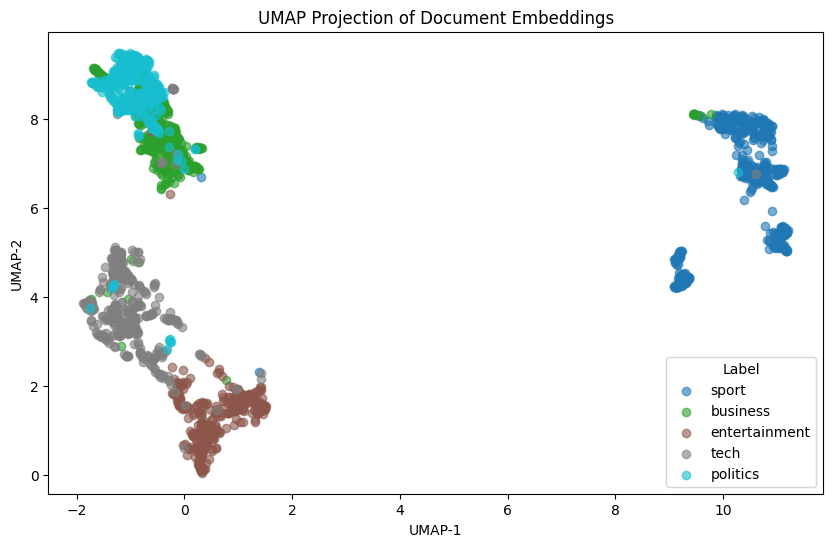

In [10]:
from sklearn.decomposition import PCA
from umap import UMAP
import matplotlib.pyplot as plt

# Step 1: PCA to reduce noise
pca = PCA(n_components=50, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

# Step 2: UMAP for nonlinear dimensionality reduction
umap_model = UMAP(n_components=10, random_state=42)
embeddings_umap = umap_model.fit_transform(embeddings_pca)

unique_labels = df["label_text"].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

# Plot 2D projection
plt.figure(figsize=(10, 6))
for i, label in enumerate(unique_labels):
    indices = df["label_text"] == label
    plt.scatter(
        embeddings_umap[indices, 0],
        embeddings_umap[indices, 1],
        label=label,
        alpha=0.6,
        color=colors[i]
    )
plt.title("UMAP Projection of Document Embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Label", loc="best")
plt.show()

This UMAP projection shows a very promising representation of document embeddings — here's a breakdown of what we observe:

### ✅ **What We See**

* **Clear Clustering by Label**:

  * Each group of points is is easily distinguishable, even if they are not perfectly separated, which means the model has learned **semantic distinctions** between topics.
  * This is especially impressive considering we’re using **zero fine-tuning** — only the raw semantic embeddings.

### 🔍 Why This Matters

* This visualization confirms that **semantic embeddings from pretrained transformers** already contain **enough structure** to group documents by topic.
* This is what allows BERTopic and other clustering tools to operate effectively with little or no supervision.

---

### 📊 Step 3: Clustering with HDBSCAN

Now that we have semantically meaningful 10-dimensional representations (via PCA + UMAP), it's time to **identify topic clusters** using an unsupervised clustering algorithm.

#### 🤖 Why HDBSCAN?

HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) is especially well-suited for topic modeling:
- ✅ **No need to pre-specify the number of clusters**.
- ✅ Can find **clusters of varying shapes and densities**.
- ✅ Automatically labels low-confidence documents as **noise** (topic -1).
- ✅ Scales well with real-world text data.

This makes HDBSCAN much more flexible than k-means or DBSCAN when working with high-dimensional language embeddings. To know more about HDBSCAN, you can read the [official documentation](https://hdbscan.readthedocs.io/en/latest/index.html).

---

#### 🧠 Goal

Group together documents that are semantically similar — using the **dense embedding space** created from MiniLM → PCA → UMAP.

In [11]:
import hdbscan

# Fit HDBSCAN on the reduced embeddings
hdb = hdbscan.HDBSCAN(min_cluster_size=15, prediction_data=True)
clusters = hdb.fit_predict(embeddings_umap)

# Attach the cluster labels to our original DataFrame
df["cluster"] = clusters

# Quick count of discovered clusters
print(f"🔍 HDBSCAN found {len(set(clusters)) - (1 if -1 in clusters else 0)} clusters.")
print(df["cluster"].value_counts())

🔍 HDBSCAN found 7 clusters.
cluster
 0    914
 1    792
 5    186
 6    136
 4     87
 3     67
 2     30
-1     13
Name: count, dtype: int64


#### 🧭 Quick Look at Clustering Results

HDBSCAN has just grouped our documents into **semantic clusters** based on their embeddings.

Here’s what we found:
- 🧠 **7 distinct clusters** (excluding noise).
- 🚫 **13 documents** were marked as noise (`cluster = -1`) — they didn’t fit confidently into any cluster.
- 📊 **Cluster 0** and **Cluster 1** dominate the dataset — containing 900+ and 700+ documents respectively.

Let’s visualize how these clusters are distributed in the embedding space!


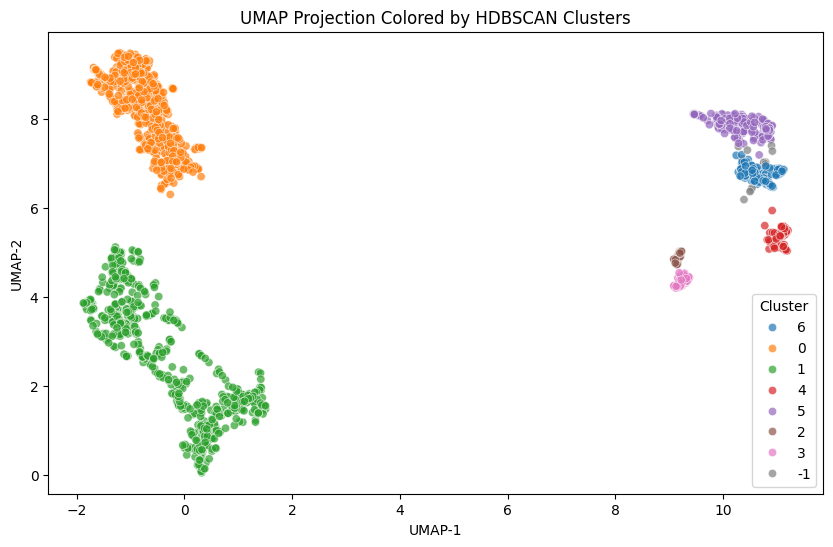

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize discovered clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=embeddings_umap[:, 0],
    y=embeddings_umap[:, 1],
    hue=df["cluster"].astype(str),
    palette="tab10",
    alpha=0.7,
    legend="full"
)
plt.title("UMAP Projection Colored by HDBSCAN Clusters")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Cluster")
plt.show()


#### 🪞 Reflecting on the Number of Clusters

Our clustering algorithm (HDBSCAN) identified **7 main clusters** in the semantic space — a relatively low number considering the diversity of the BBC news dataset. Also we see that the clusters are not perfectly separated when looking at the whole dataset at the same time.

This can be both a strength and a limitation:

- ✅ **Strength**: These clusters represent **broad, high-level themes**, giving a clean summary of the corpus.
- ⚠️ **Limitation**: If we want **finer-grained insights**, like subtopics or emerging trends, we may need to **dive deeper**.

👉 That’s one of the main strengths of the full **BERTopic pipeline**:
- The parametrization is well set to find a good balance between granularity and separation.
- To get more clusters, we can either increase the `min_cluster_size` or the `n_components` in the UMAP.

Now, let’s interpret what each of our current clusters means by **extracting representative keywords** using the **c-TF-IDF** technique — a cornerstone of BERTopic's representation strategy.

--- 

### 🧠 Step 4: Topic Representation using c-TF-IDF

Once documents are grouped into clusters, the next challenge is:  
➡️ **How do we describe each topic?**

Instead of simply counting word frequency, BERTopic uses a smarter approach called **class-based TF-IDF (c-TF-IDF)**:

---

#### 🔍 What is c-TF-IDF?

c-TF-IDF adapts the traditional TF-IDF logic to topic modeling:
- Imagine each topic is one big document (by concatenating all its documents).
- Then, compute the TF-IDF score of words within that “topic-document” relative to all others.
- This highlights **keywords that are specific to one topic**, not just common overall.

---

#### 📌 Why Use c-TF-IDF?

- ✅ It captures **topic-specific terminology**.
- ✅ It works well even for **short texts** (like news headlines).
- ✅ It’s **unsupervised** and leverages your cluster labels to build meaning.

Now let’s compute the top terms per topic using this technique and look at what defines each cluster semantically.


In [13]:
from bertopic.vectorizers import ClassTfidfTransformer

# Step 1: Create pseudo-documents per cluster
docs_per_topic = {}
for topic in set(clusters):
    if topic == -1:
        continue  # Skip outliers
    topic_docs = [doc for doc, label in zip(df["document"], clusters) if label == topic]
    docs_per_topic[topic] = " ".join(topic_docs)

# Step 2: Extract raw vocabulary
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words="english")
X = vectorizer.fit_transform(docs_per_topic.values())

# Step 3: Compute c-TF-IDF
ctfidf = ClassTfidfTransformer()
# Fix: Don't pass the document texts as the multiplier
X_ctfidf = ctfidf.fit_transform(X)

# Step 4: Get top terms per topic
def get_top_n_words_per_topic(X_ctfidf, vectorizer, n=10):
    words = vectorizer.get_feature_names_out()
    top_words = {}
    for topic_idx in range(X_ctfidf.shape[0]):
        row = X_ctfidf[topic_idx].toarray().flatten()
        top_n = row.argsort()[-n:][::-1]
        top_words[topic_idx] = [words[i] for i in top_n]
    return top_words

top_words = get_top_n_words_per_topic(X_ctfidf, vectorizer)
for topic, words in top_words.items():
    print(f"🧩 Topic {topic}: {', '.join(words)}")

🧩 Topic 0: said, mr, government, labour, year, election, new, people, blair, party
🧩 Topic 1: said, people, film, music, new, best, year, mobile, tv, technology
🧩 Topic 2: kenteris, iaaf, doping, drugs, thanou, greek, conte, athletes, test, athens
🧩 Topic 3: race, olympic, indoor, world, champion, holmes, championships, year, european, athens
🧩 Topic 4: open, roddick, seed, set, australian, win, match, final, nadal, tennis
🧩 Topic 5: club, chelsea, united, arsenal, liverpool, league, said, game, manager, football
🧩 Topic 6: england, wales, ireland, rugby, france, nations, game, half, coach, robinson


### 🏷️ Step 5: Naming Topics with Keywords or LLM

Now that we’ve extracted **top keywords per topic** using c-TF-IDF, which was used for the first version of BERTopic, the next step is to give each cluster a human-readable name which is possible thanks to the `representation_model` parameter in BERTopic but most especially because of the LLMs.

---

#### ✏️ Manual Naming (Basic Approach)

You could simply:
- Look at the **top 5–10 keywords** per topic.
- Assign a **human-readable label** based on those terms.

> For example, a cluster with words like `economy`, `stocks`, `market`, `inflation` → likely represents a topic about **Business & Finance**.

---

#### 🤖 LLM-Based Naming (Optional, Smart Approach)

We can go further and use an LLM (like GPT-4 or Claude) to:
- Read the keywords + a few sample docs.
- Generate a **short, descriptive title** for each cluster.

This is what BERTopic does under the hood with `representation_model=LiteLLM(...)`.

---

Let’s now write a helper function to name our topics automatically by summarizing the top keywords per cluster. Later, we’ll also look at a few sample docs from each cluster for deeper insights.


In [15]:
from litellm import completion
import time

# Generate a title for each topic
topic_titles = {}
for topic_id, keywords in top_words.items():
    docs = docs_per_topic[topic_id][:5]  # take 5 example docs
    
    # Create a simple prompt with the documents and keywords
    prompt = f"""
    I have a topic that contains the following documents:
    {docs}
    
    The topic is described by the following keywords: {keywords}
    
    Based on the above information, please provide a concise title for this topic.
    
    Format:
    title: <title>
    """
    
    # Call gpt-4o-mini directly
    response = completion(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}]
    )
    
    # Extract the title
    response_text = response.choices[0].message.content
    title = response_text.split("title:")[-1].strip() if "title:" in response_text.lower() else "Unknown Title"
    
    topic_titles[topic_id] = title
    print(f"📌 Topic {topic_id}: {title}")
    
    # Add delay to avoid rate limits
    time.sleep(3)

📌 Topic 0: China and the Impact of Government and Elections
📌 Topic 1: "Current Trends in Music and Film Technology"
📌 Topic 2: Greek Athletes and Doping Controversies in Athens
📌 Topic 3: Lewis Holmes: European Indoor World Champion in Athletics
📌 Topic 4: "Australian Open Final: Nadal's Match Victory"
📌 Topic 5: Premier League Football Clubs: Chelsea, United, Arsenal, and Liverpool Insights
📌 Topic 6: "Rugby Nations: Wales and its Place Amongst England, Ireland, and France"


## ✅ Conclusion: BERTopic & Custom Topic Modeling Uncovered

In this notebook, we explored BERTopic approach to topic modeling:

---

### 🔍 1. Using BERTopic + LLMs (LiteLLM + GPT-4o)

We began by leveraging [**BERTopic**](https://github.com/MaartenGr/BERTopic), a high-level, production-ready tool that:
- Uses **sentence embeddings** and **density-based clustering** (UMAP + HDBSCAN).
- Allows easy interpretation of topics through **keyword extraction** and **LLM-generated titles/summaries** via LiteLLM.

It enabled us to quickly and meaningfully explore the **BBC News dataset**, generating high-quality clusters and intuitive representations with minimal effort.

---

### 🔬 2. Rebuilding the Pipeline from Scratch

Then, we took a deep dive to **understand what BERTopic does under the hood**, step by step:
1. Computed **MiniLM embeddings** of documents.
2. Applied **PCA + UMAP** for dimensionality reduction.
3. Used **HDBSCAN** for clustering documents into coherent groups.
4. Extracted **keywords per cluster** using `c-TF-IDF`.
5. Used **GPT-4o via LiteLLM** to generate human-readable **titles**.

---

### 🧠 Why It Matters

This dual approach gave us:
- A powerful plug-and-play experience with BERTopic.
- A deeper understanding of how topic modeling pipelines work, and how we can customize or extend them for our own needs.

From quick exploration to full interpretability, **topic modeling + LLMs** form a great toolkit for real-world text mining.

---

Whether you want speed, control, or insight — this notebook sets the foundation for all three.